In [1]:
%load_ext autoreload

In [3]:
%autoreload 2

In [7]:
import os
os.chdir("EMBER-updated/")

In [8]:
import time
import copy
import random
import numpy as np
import math

from sklearn.metrics import roc_curve, auc
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.utils.data as data_utils

from multiclassifier import Model

seedy = 666
random.seed(seedy)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Meow function to run after model is finished training.

In [9]:
def allDone():
    return "All Done!" # Audio('meow.wav', autoplay=True)

### Load motif data.

In [10]:
train_motifs = np.genfromtxt('data/7472_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data/7472_motifxFamMatrix.csv',delimiter=',',dtype=int)
test_motifs = np.genfromtxt('data/1643_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data/1643_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data/large_fams.csv',dtype='U')

## Split data into folds in a stratified k-fold manner.

def proba_mass_split(y, folds=5):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
    return index_list

np.random.seed(seedy)
folds = proba_mass_split(train_motifxFamMatrix)

### Load embedding coordinates and kinase family distances.

In [11]:
#############################################
# Get Siamese embedding coords.
#############################################

embedding = np.genfromtxt('MODELS_siam/emb_??_embedding.csv',delimiter=',',dtype=float)
train_embedding = embedding[ :len(train_motifs) ]
test_embedding = embedding[ len(train_motifs): ]
print(embedding.shape)

#############################################
# Get fam distance matrix for Phylo MSE loss.
#############################################

all_fams = (np.genfromtxt('data/fam_distances_blos62/fams.csv',dtype='U'))
dist_matrix = (np.genfromtxt('data/fam_distances_blos62/dist_matr_new.csv',delimiter=',',dtype=float))

fam_idc = [np.where(all_fams==fam)[0][0] for fam in fams]
fam_dist_matrix = dist_matrix[fam_idc][:,fam_idc]
        
# normalize fam distances
fMax = np.max(fam_dist_matrix)
fMin = np.min(fam_dist_matrix)

fam_dist_matrix_scaled = np.array((fam_dist_matrix))
for i in range(len(fams)):
    for j in range(len(fams)):
        fam_dist_matrix_scaled[i][j] = 1 - float(fam_dist_matrix[i][j]-fMin)/(fMax-fMin) 
fam_dist_matrix = fam_dist_matrix_scaled

famDistMatrix = fam_dist_matrix

(9115, 100)


### Misc functions for data pre-processing.

In [12]:
AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'

def get_oneHot_motifs(motifs, AMINOS=AMINOS):
    oneHot_motifs = []
    for motif in motifs:
        one_hotted = np.zeros((len(motif), len(AMINOS)),dtype=float)
        for i,aa in enumerate(motif):
            hot = AMINOS.find(aa)
            one_hotted[i][hot] = 1
        oneHot_motifs.append(one_hotted)
    oneHot_motifs = np.asarray(oneHot_motifs)
    oneHot_motifs = np.swapaxes(oneHot_motifs,1,2)
    return oneHot_motifs

def get_stacked_features(motifs, embeddings):
    oneHot_motifs = get_oneHot_motifs(motifs)
    squished_oneHots = oneHot_motifs.reshape(oneHot_motifs.shape[0],oneHot_motifs.shape[1]*
                                         oneHot_motifs.shape[2])
    stacked_features = np.hstack((squished_oneHots,embeddings))
    stacked_features = torch.tensor(stacked_features)
    return stacked_features        


def get_loader(motifs,embedding,motifxFamMatrix,idc,my_batch):
    these_motifs = motifs[idc]
    this_embedding = embedding[idc]
    X = get_stacked_features(these_motifs,this_embedding)
    Y = torch.tensor(motifxFamMatrix[idc])
    dataset = data_utils.TensorDataset(X, Y)
    loader = data_utils.DataLoader(dataset, batch_size=my_batch, shuffle=True, drop_last=True)
    return loader

### Model training functions.

In [13]:
def get_microROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(fams)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
    return auc(fpr_micro, tpr_micro)

def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs, stopper='loss', 
                version='seq-coord', this_loss='phylo'):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    running = - math.inf
    current = running
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        
        print("Epoch",epoch+1)
        for phase in ['train','validate']:
            running_loss = 0.0
            running_acc = 0.0
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
            for inputs,labels in loader:
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                motif = inputs[:,:-embedding.shape[1]].reshape( batch_size, len(AMINOS), len(train_motifs[0]) )
                coords = inputs[:,-embedding.shape[1]:]

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model.forward(motif, coords, version)
                    if this_loss=='phylo' and version=='seq-coord':
                        loss = phylo_error(outputs,labels)
                    elif this_loss!='phylo':
                        criterion = nn.BCELoss() # BCE loss is the usual loss to use.
                        loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()

                y_test = np.asarray(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                acc = get_microROC(y_test, y_score)
                running_acc += acc
            
            loss = running_loss / len(loader) 
            acc =  running_acc / len(loader) 
            
            if phase=='train':
                train_losses.append(loss)
                train_accs.append(acc)
                
            elif phase=='validate':
                val_losses.append(loss)
                val_accs.append(acc)
                
                if stopper=='loss':
                    current = -loss
                elif stopper=='acc':
                    current = acc
                elif stopper=='epoch':
                    current = epoch
                if current >= running:
                    running = current
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
            print("~ %s LOSS: %5.3f | ACC: %5.3f" % (phase,loss,acc))
            if current >= running and phase=='validate':
                print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_losses, train_accs, val_losses, val_accs)

### "Phylogenetic" loss function.

In [14]:
def phylo_error(output, target):
        
    weights = np.ones((output.shape[0],output.shape[1]))

    for i,t in enumerate(target):
        t = t.cpu()
        wIdc = np.where(t.detach().numpy()==1)[0]

        if len(wIdc)==0:
            weights[i] = 0.000001
            continue
        theseWeights = np.ones((len(fams)))
        
        for wIdx in wIdc:
            thisWeight = famDistMatrix[wIdx].copy() # inter-fam
            thisWeight[wIdx] =  1.00 - famDistMatrix[wIdx][wIdx].copy() # intra-fam
            theseWeights+=thisWeight # add to existing list of fam distances, respectively (element wise)
            
        fWeight = theseWeights/len(fams) # take median / average
        weights[i] = fWeight 
        
    weights = torch.tensor(weights)
    weights = weights.to(device)
    crit = nn.BCELoss(reduction=my_reduction)
    answer = crit(output, target) * weights.mean().float()

    return answer

### If training new model, set your parameters.

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # #
my_version = 'seq-coord'        
my_loss = 'phylo'            

my_stopper = 'loss'
my_batch = 32
my_epochs = 5
my_lr = 0.0015

my_reduction = 'sum'
# # # # # # # # # # # # # # # # # # # # # # # # # # #

### Train all 5 models.

In [16]:
import warnings
warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")

In [19]:
s = time.time()

all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

all_best_runs = []
all_models = []

for i,fold in enumerate(folds):
    
    print("\n* * * * * * * * FOLD %d * * * * * * * *\n" %(i+1))
    
    fold_val_idc = fold
    fold_train_idc = [x for x in range(len(train_motifs)) if x not in fold_val_idc]
    
    train_loader = get_loader(train_motifs,train_embedding,train_motifxFamMatrix,fold_train_idc,my_batch)
    val_loader = get_loader(train_motifs,train_embedding,train_motifxFamMatrix,fold_val_idc,my_batch)
    
    model = Model()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = my_lr)
    
    (best_run, best_model, train_losses, train_accs, val_losses, val_accs) = \
                    train_model(train_loader, val_loader,
                                model, optimizer,my_batch, 
                                my_epochs,my_stopper,my_version,
                                my_loss)
    
    all_best_runs.append(best_run)
    all_models.append(best_model)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)
    
print("TIME: %5.3f mins" % ((time.time()-s)/60))
print("BEST RUNS:",all_best_runs)

allDone()


* * * * * * * * FOLD 1 * * * * * * * *

Epoch 1
~ train LOSS: 7.400 | ACC: 0.760
~ validate LOSS: 7.498 | ACC: 0.857
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 2.900 | ACC: 0.875
~ validate LOSS: 5.879 | ACC: 0.860
      BEST SO FAR ^ ^ ^

* * * * * * * * FOLD 2 * * * * * * * *

Epoch 1
~ train LOSS: 7.547 | ACC: 0.793
~ validate LOSS: 7.335 | ACC: 0.852
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 2.901 | ACC: 0.874
~ validate LOSS: 64.586 | ACC: 0.500

* * * * * * * * FOLD 3 * * * * * * * *

Epoch 1
~ train LOSS: 7.803 | ACC: 0.764
~ validate LOSS: 62.023 | ACC: 0.546
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 2.898 | ACC: 0.875
~ validate LOSS: 64.587 | ACC: 0.500

* * * * * * * * FOLD 4 * * * * * * * *

Epoch 1
~ train LOSS: 7.268 | ACC: 0.802
~ validate LOSS: 15.212 | ACC: 0.860
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 2.900 | ACC: 0.874
~ validate LOSS: 25.549 | ACC: 0.861

* * * * * * * * FOLD 5 * * * * * * * *

Epoch 1
~ train LOSS: 7.088 | ACC: 0.791
~ validate LO

'All Done!'

### Save all 5 models.

In [20]:
# # # # # # # # # # # #
run = 'new'
# # # # # # # # # # # #

import os
if not os.path.exists("MODELS_multiclass/%s/" % run):
    os.makedirs("MODELS_multiclass/%s/" % run)
for i,model_weights in enumerate(all_models):
    torch.save(model_weights, "MODELS_multiclass/%s/%d_weights" % (run,i))

### Plot losses and accuracies across epochs.

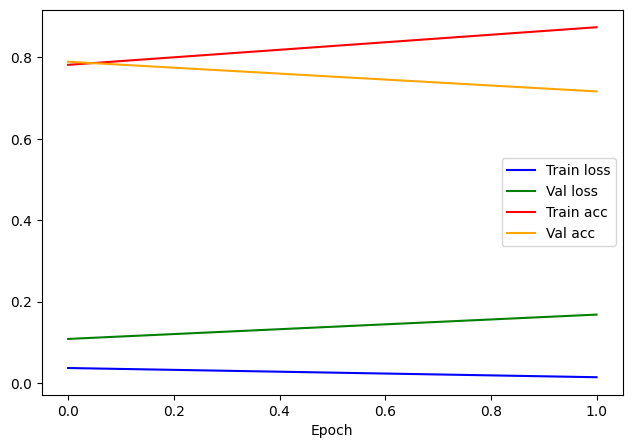

In [21]:
all_train_losses_arr = np.zeros(my_epochs)
all_train_accs_arr = np.zeros(my_epochs)
all_val_losses_arr = np.zeros(my_epochs)
all_val_accs_arr = np.zeros(my_epochs)

for i in range(my_epochs):
    all_train_losses_arr[i] = sum([all_train_losses[j][i] for j in range(len(folds))]) / len(folds)
    all_train_accs_arr[i] = sum([all_train_accs[j][i] for j in range(len(folds))]) / len(folds)
    all_val_losses_arr[i] = sum([all_val_losses[j][i] for j in range(len(folds))]) / len(folds)
    all_val_accs_arr[i] = sum([all_val_accs[j][i] for j in range(len(folds))]) / len(folds)
    
if my_reduction=='sum':
    all_train_losses_arr=all_train_losses_arr*.005
    all_val_losses_arr=all_val_losses_arr*.005
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7.5,5))

plt.plot(all_train_losses_arr,label='Train loss',c='blue')
plt.plot(all_val_losses_arr,label='Val loss',c='green')
plt.plot(all_train_accs_arr,label='Train acc',c='red')
plt.plot(all_val_accs_arr,label='Val acc',c='orange')

plt.xlabel("Epoch")
plt.legend(loc='center right')
plt.savefig("FIGS_multiclass/" + run + "_loss-acc")

plt.show()